In [580]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.matlib

In [581]:
# STEP 1: Assign memory for the weights matrix and create an environment with a cell representing each location

rows = 10
cols = 10
nCells = rows *cols
weightsMat = np.zeros(((rows, cols, nCells)))
nIterations = 15
NetThreshold = 0.7
sensorySigma = 3.5

# Create an index sheet for the PC output
PC_idx = np.arange(rows * cols).reshape(rows, cols)

In [582]:
# function to create a 3D plot of the firing rates of cells

def create3Dplot(rows,cols,Z):
    # Generate the grid
    x = np.arange(0, rows, 1)  # Equivalent to -5:0.1:5 in MATLAB
    y = np.arange(0, cols, 1)
    X, Y = np.meshgrid(x, y)

    # Create the 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    # Add labels and title

    ax.set_title('3D Surface Plot')

    # Add a colour bar for the surface
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Show the plot
    plt.ion()
    plt.show()
    plt.pause(0.001)
    input("Press Enter to continue...")  # Wait for the user to press Enter
    plt.close(fig)

In [583]:
# Define the Gaussian function for firing fields
def gaussian(X, Y, cx, cy, sigma=sensorySigma):
    """
    Computes a 2D Gaussian function centered at (cx, cy).
    
    Parameters:
    X, Y   : 2D arrays representing the coordinate grid where the Gaussian is evaluated.
    cx, cy : Coordinates of the Gaussian center.
    sigma  : Standard deviation, controlling the spread of the Gaussian (default is 6).
    
    Returns:
    A 2D array with Gaussian values at each (X, Y) position.
    """
    
    # Compute the squared distance from the center (cx, cy) for each grid point
    distance_sq = (X - cx) ** 2 + (Y - cy) ** 2
    
    # Compute the Gaussian function using the standard formula
    gauss = np.exp(-distance_sq / (2 * sigma ** 2))
    
    return gauss / np.max(gauss)

In [584]:
# STEP 2: Initialise the weights in the weights matrix
    # The cell has a weight of 1 with itself and a weight of 0.5 with it's immediate neighbours
    
for cell in range(nCells): # cycle through each cell
    r, c = np.where(PC_idx == cell) # find the position of that cell in the PC sheet
    
    weightsMat[r,c,cell] = 1 # Set weight with itself to 1
    
    if r>0:   # If the row is not the top...
        weightsMat[r-1,c,cell] = 0.5
    if r<rows-1: # If row is not at the bottom... (Have to -1 because of python zero idx)
        weightsMat[r+1,c,cell] = 0.5
    if c>0:
        weightsMat[r,c-1,cell] = 0.5
    if c<cols-1: # Have to -1 because of zero idx
        weightsMat[r,c+1,cell] = 0.5
        

In [585]:
#Step 4: Create a sheet of sensory cells with Gaussian firing fields
nSensoryCells = 10
SensoryFiringFields = np.zeros((rows,cols,nSensoryCells)) # Create an empty matrix, one sheet for each cell, environment the same size as the attractor

# Choose 10 approximately equally spaced row and column indices
nCentre_rows = int(np.sqrt(nSensoryCells))
nCentre_cols = int(np.ceil(nSensoryCells / nCentre_rows))
row_indices = np.linspace(0, rows - 1, nCentre_rows, dtype=int)  # 5 rows
col_indices = np.linspace(0, cols - 1, nCentre_cols, dtype=int)  # 2 columns

# Create all combinations of row and column indices
centers = [(r, c) for r in row_indices for c in col_indices][:nSensoryCells]


# Create grid (X, Y) for the environment
X, Y = np.meshgrid(np.arange(rows), np.arange(cols))

# Compute Gaussian firing fields for each sensory cell center
for i, (cx, cy) in enumerate(centers):
    SensoryFiringFields[:,:,i] = gaussian(X, Y, cx, cy)

/var/folders/5n/kdl3dytn7171_kqch0_4jk2c0000gn/T/ipykernel_91179/3691937786.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


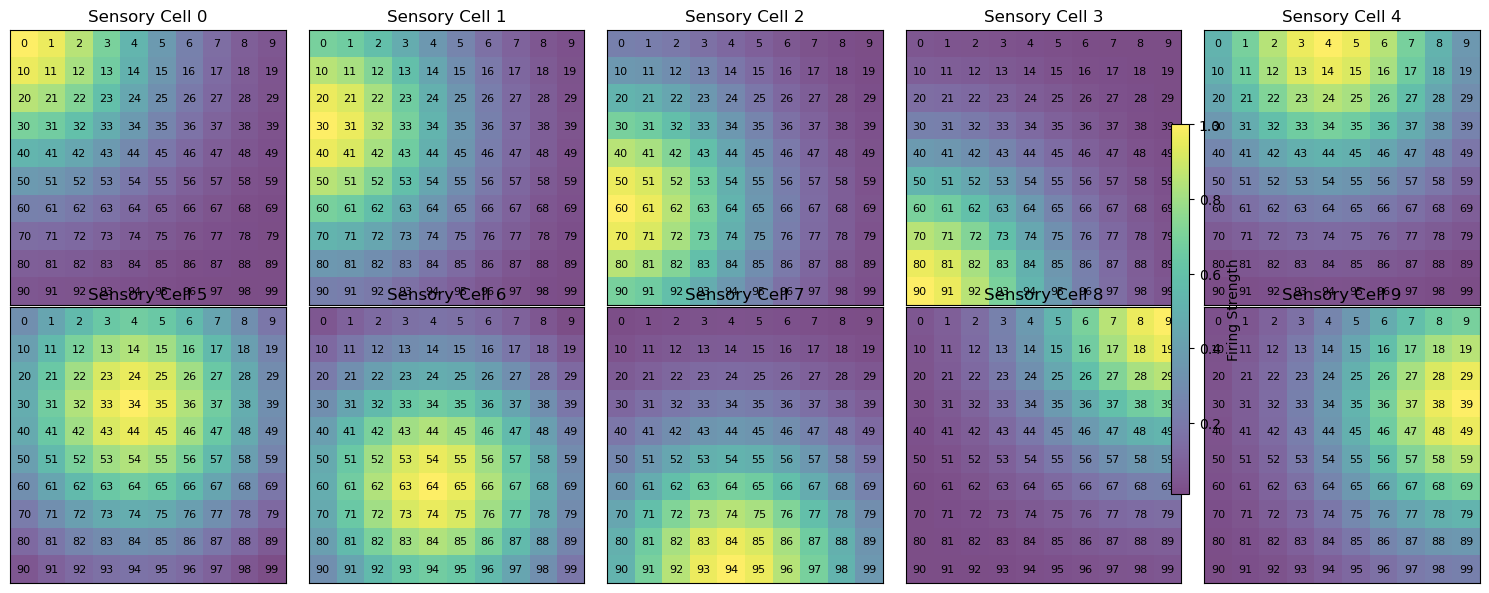

In [586]:
# Create figure with subplots for all sensory cells
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten axes for easy iteration

for i, ax in enumerate(axes):
    # Plot the sensory firing field for sensory cell i
    im = ax.imshow(SensoryFiringFields[:, :, i], origin='upper', cmap='viridis', alpha=0.7)

    # Overlay the place cell indices
    for r in range(PC_idx.shape[0]):
        for c in range(PC_idx.shape[1]):
            ax.text(c, r, f"{PC_idx[r, c]}", ha='center', va='center', color='black', fontsize=8)

    ax.set_title(f'Sensory Cell {i}')
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar for reference
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label="Firing Strength")

plt.tight_layout()
plt.show()

In [587]:
# STEP 5: Create a weights matrix between the sensory cells and attractor cells
sensoryWeights = np.zeros((nSensoryCells, nCells))

# Iterate over each place cell
for cell in range(nCells):
    r, c = np.where(PC_idx == cell) # find the position of the cell in the PC sheet

    # Extract firing rates from all sensory cells at this location
    sensoryWeights[:, cell] = SensoryFiringFields[r, c,:]


print("Weights matrix shape:", sensoryWeights.shape)


Weights matrix shape: (10, 100)


In [588]:
# Step 6: Create a Trajectory
# for now we are just going to select a position, later we will create a trajectory with a new position at each timestep

position = 12
pcRow, pcCol = np.where(PC_idx == position)
pcRow, pcCol = pcRow[0], pcCol[0]  # Extract integer values


# Find the sensory activity at that position
currentSensoryActivity = SensoryFiringFields[pcRow,pcCol,:]

currentSensoryActivity = np.transpose([currentSensoryActivity]) #transpose to column vector
print(currentSensoryActivity)

currentSensoryActivity = np.matlib.repmat(currentSensoryActivity,1,nCells) #replicate for ease of multiplication with weights
#print(currentSensoryActivity.shape)


sensoryInput = currentSensoryActivity*sensoryWeights # elementwise multiplication of sensory activity and weights
sensoryInput = np.sum(sensoryInput, axis=0) # sum the columns to give a single sensory value per place cell
sensoryInput = sensoryInput*4
 # multiply by a scaling factor


[[0.81539581]
 [0.72142229]
 [0.30615203]
 [0.06231767]
 [0.81539581]
 [0.72142229]
 [0.30615203]
 [0.06231767]
 [0.12992261]
 [0.11494916]]


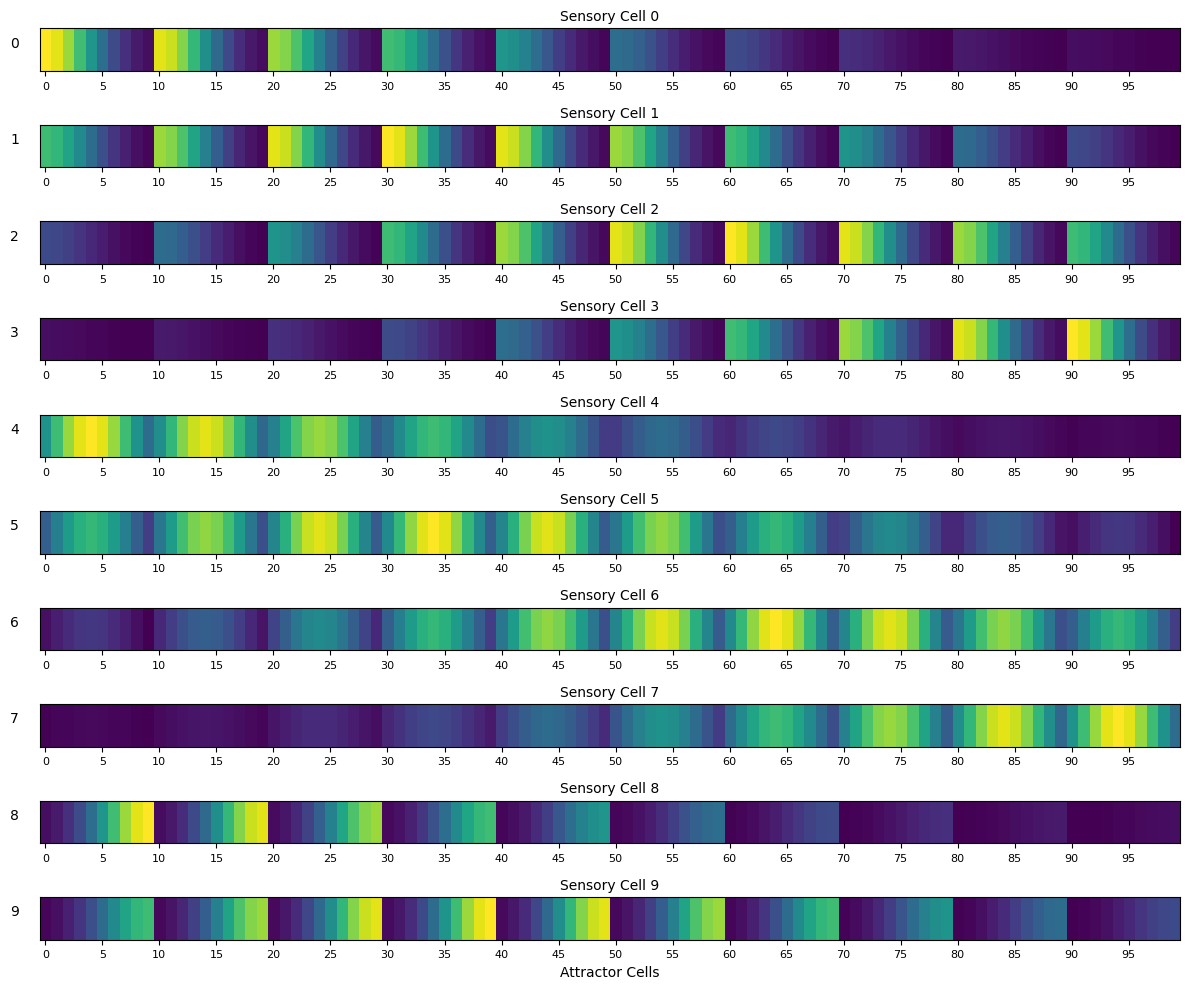

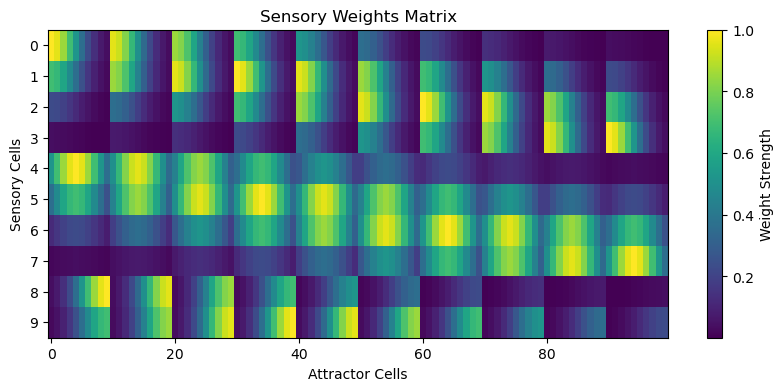

In [589]:
# Create a figure with 10 subplots (1 for each sensory cell)
fig, axes = plt.subplots(10, 1, figsize=(12, 10), sharex=True)  # 10 rows, 1 column

for i, ax in enumerate(axes):
    ax.imshow(sensoryWeights[i, :].reshape(1, -1), aspect='auto', cmap='viridis')
    ax.set_title(f'Sensory Cell {i}', fontsize=10)
    ax.set_yticks([])  # Remove y-axis ticks for cleaner look
    ax.set_ylabel(f'{i}', rotation=0, labelpad=15, fontsize=10, ha='right')

    # Ensure x-axis labels on every subplot
    ax.set_xticks(np.arange(0, 100, 5))  # Set ticks every 5 units
    ax.set_xticklabels(np.arange(0, 100, 5), fontsize=8)  # Force labels on all subplots
    ax.tick_params(axis='x', which='both', labelbottom=True)  # Ensure labels are visible

# Set common x-axis label
axes[-1].set_xlabel("Attractor Cells")

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))  # Adjust width and height to fit the matrix
plt.imshow(sensoryWeights, aspect='auto', cmap='viridis')

# Set y-axis ticks to show all sensory cell indices (0-9)
plt.yticks(np.arange(10), labels=np.arange(10))

plt.colorbar(label="Weight Strength")
plt.xlabel("Attractor Cells")
plt.ylabel("Sensory Cells")
plt.title("Sensory Weights Matrix")

plt.show()

In [590]:
# Step 3: Set initial firing rate in the enviornment
NetAct = np.random.uniform(low=0, high=2, size=(rows, cols))  # Add noise

# Alternativly set initial activation to a specific value
#NetAct= (np.ones((rows, cols)))/2; #Set inital activity to 0.5


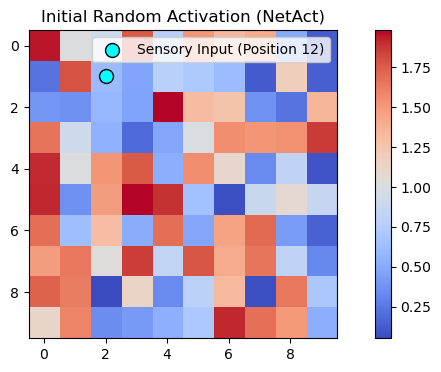

In [591]:
# Store the initial random activation
initialNetAct = NetAct.copy()
# Plot initial activation
plt.figure(figsize=(10, 4))
plt.imshow(initialNetAct, cmap='coolwarm')
plt.title("Initial Random Activation (NetAct)")
plt.colorbar()

# Mark the sensory input location
plt.scatter(pcCol, pcRow, color='cyan', s=100, edgecolors='black', label='Sensory Input (Position 12)')
plt.legend()
plt.show()


Max value: 1.000, Sum: 17.726, Active cells: 24
Peak position: (8, 3), Place cell index: 83


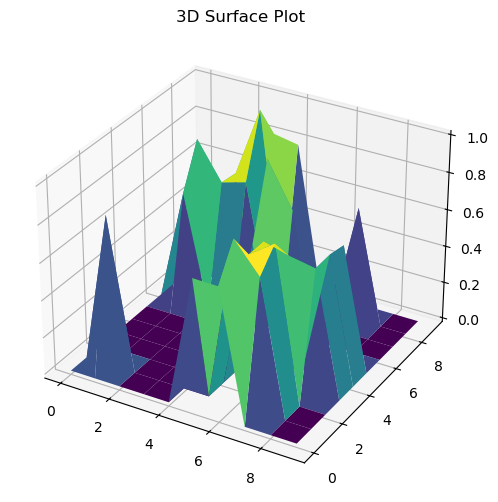

Max value: 1.000, Sum: 13.408, Active cells: 17
Peak position: (8, 3), Place cell index: 83


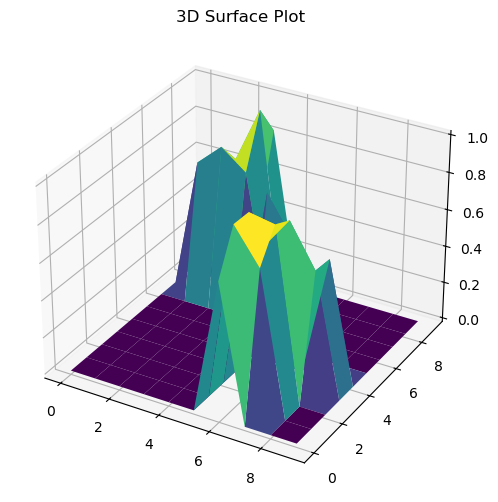

Max value: 1.000, Sum: 9.247, Active cells: 11
Peak position: (2, 6), Place cell index: 26


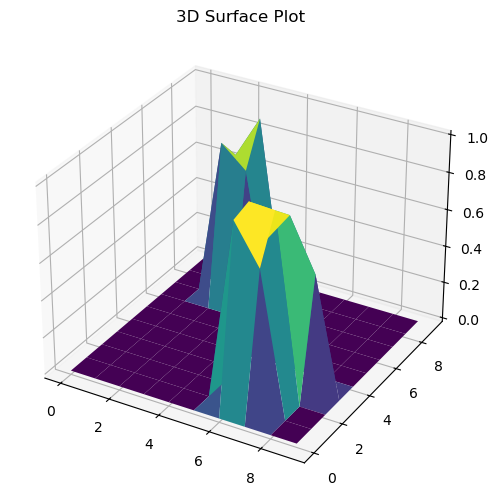

Max value: 1.000, Sum: 7.913, Active cells: 10
Peak position: (2, 6), Place cell index: 26


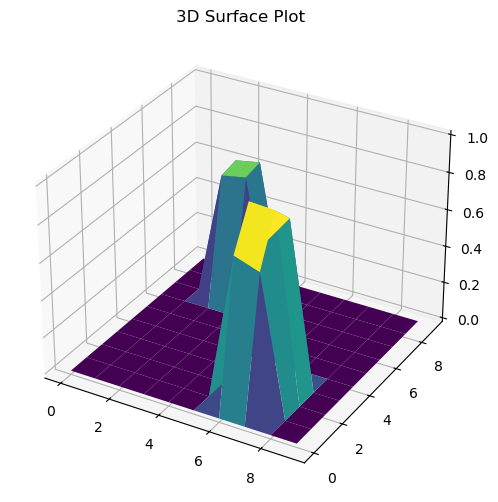

Max value: 1.000, Sum: 6.697, Active cells: 9
Peak position: (2, 7), Place cell index: 27


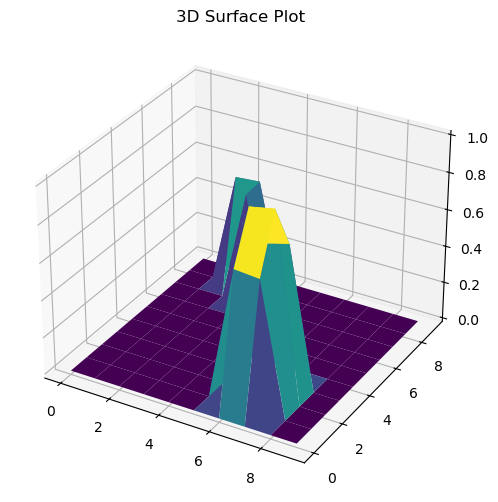

Max value: 1.000, Sum: 4.841, Active cells: 6
Peak position: (2, 7), Place cell index: 27


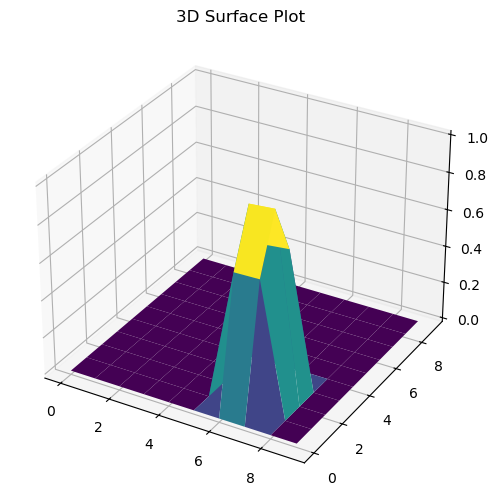

Max value: 1.000, Sum: 4.827, Active cells: 6
Peak position: (2, 7), Place cell index: 27


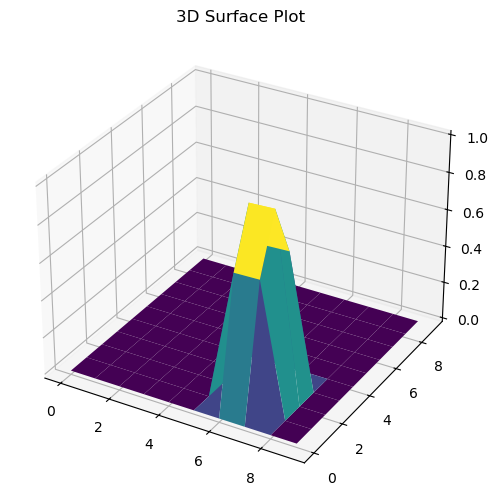

Max value: 1.000, Sum: 4.825, Active cells: 6
Peak position: (2, 7), Place cell index: 27


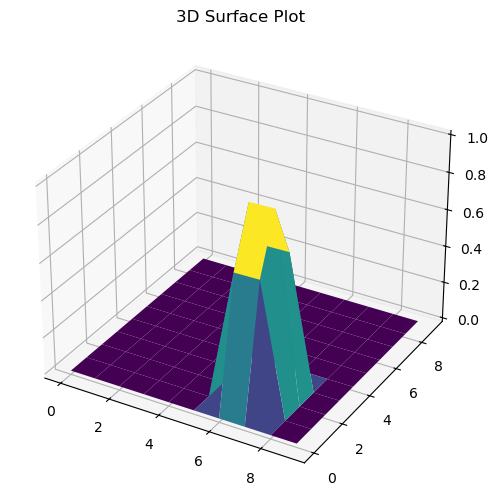

Max value: 1.000, Sum: 4.826, Active cells: 6
Peak position: (2, 7), Place cell index: 27


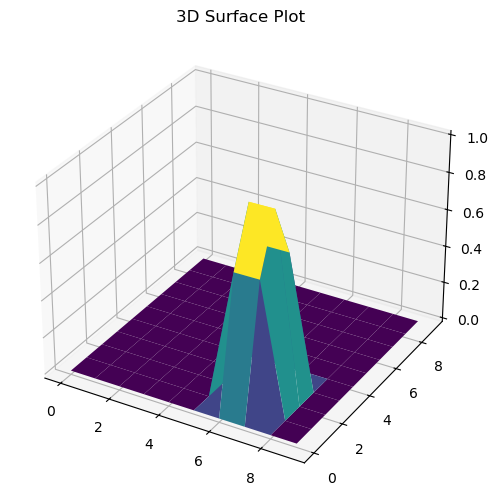

Max value: 1.000, Sum: 4.827, Active cells: 6
Peak position: (2, 7), Place cell index: 27


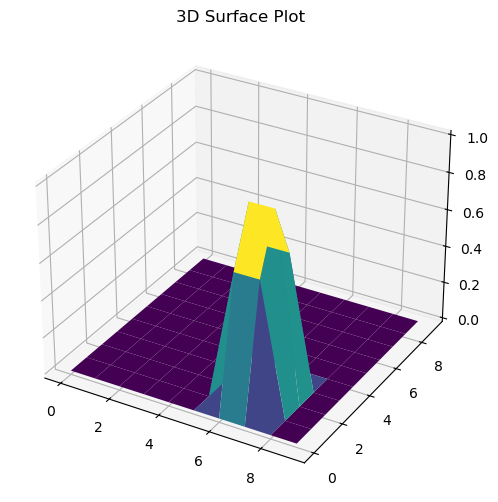

Max value: 1.000, Sum: 4.827, Active cells: 6
Peak position: (2, 7), Place cell index: 27


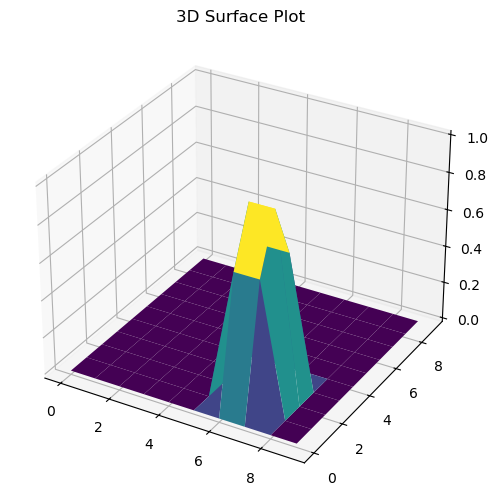

Max value: 1.000, Sum: 4.828, Active cells: 6
Peak position: (2, 7), Place cell index: 27


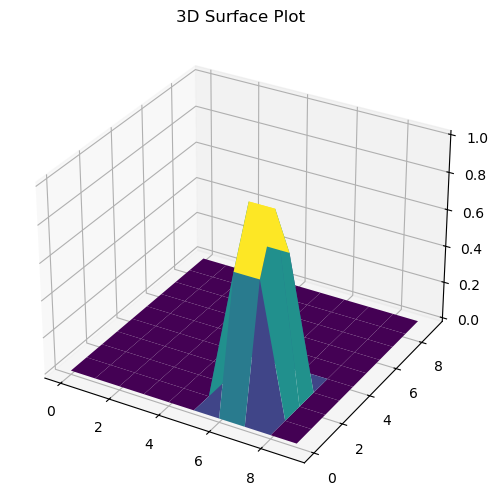

Max value: 1.000, Sum: 4.828, Active cells: 6
Peak position: (2, 7), Place cell index: 27


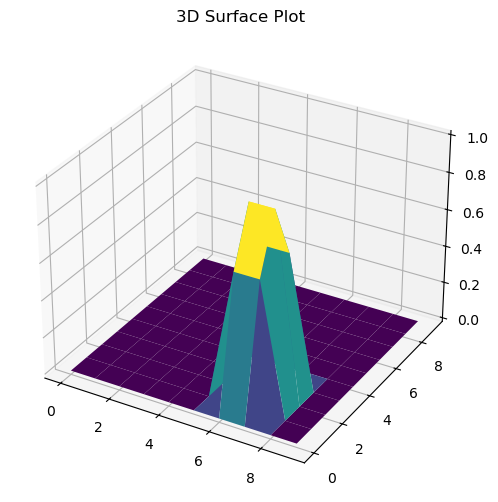

Max value: 1.000, Sum: 4.828, Active cells: 6
Peak position: (2, 7), Place cell index: 27


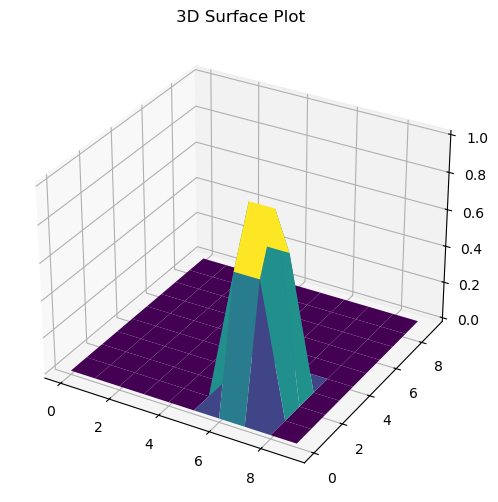

Max value: 1.000, Sum: 4.828, Active cells: 6
Peak position: (2, 7), Place cell index: 27


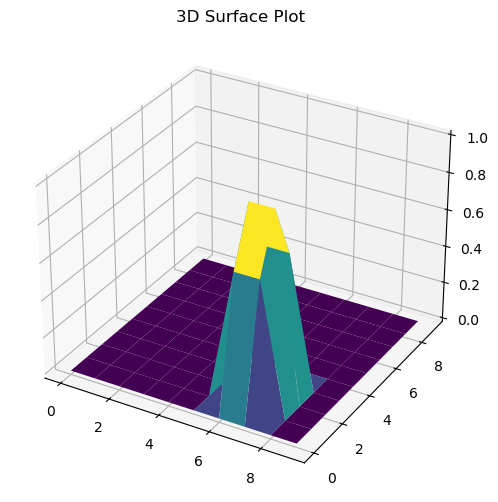

In [ ]:
# Step 4: Calculate the firing of each cell
for _ in range(nIterations):
    NetInput = np.zeros((rows,cols)) # create a temporary store of cell activity so they don't interact
    for k in range(nCells):
        row,col = np.where(PC_idx == k) # find row and column index of cell
        NetInput = NetInput+weightsMat[:,:,k]*NetAct[row,col] + sensoryInput[k] # New activity = old activity * weights (summed across cells) + sensory Input
    NetInput = NetInput-np.min(NetInput) # Non-linearity
    NetInput = NetInput / np.max(NetInput)  # Normalise to values between 0 & 1
                   # Clear the figure for the next iteration
    NetInput = NetInput * (NetInput >= NetThreshold)  # Threshold
    NetAct = NetInput.copy()  # Set Input to each cell as the new firing rate
   # DEBUG PRINTS
    max_idx = np.unravel_index(np.argmax(NetAct), NetAct.shape)
    flat_pc_idx = np.ravel_multi_index(max_idx, NetAct.shape)
    print(f"Max value: {np.max(NetAct):.3f}, Sum: {np.sum(NetAct):.3f}, Active cells: {np.count_nonzero(NetAct)}")
    print(f"Peak position: {max_idx}, Place cell index: {flat_pc_idx}")

    # Plot current network state
    create3Dplot(rows, cols, NetAct)  # plot - you need to press Enter to progress on to next iteration
    
# sensoryInput[k] is a scalar being added across the entire 2D NetInput grid — once per k
# That results in every cell getting 100 additions of 100 scalars, which likely overwhelms spatial specificity
# The bump’s location became unstable and random, even when the sensory input position was fixed.

Max value: 1.000, Sum: 33.769, Active cells: 39
Peak position: (4, 2), Place cell index: 42


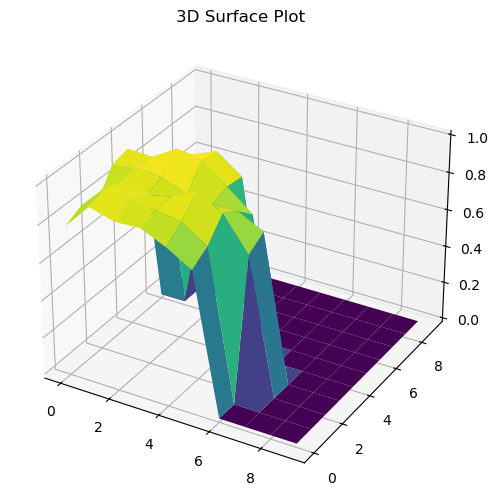

Max value: 1.000, Sum: 27.225, Active cells: 31
Peak position: (2, 2), Place cell index: 22


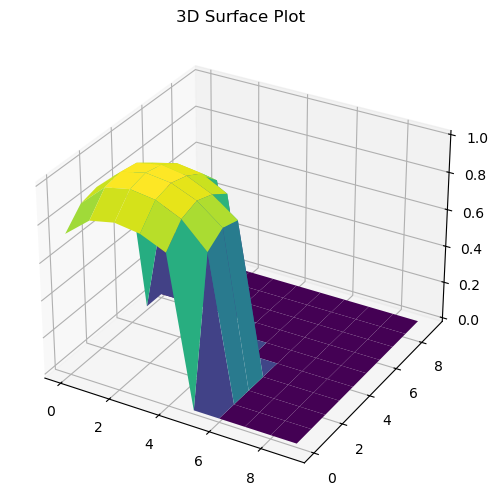

Max value: 1.000, Sum: 25.629, Active cells: 30
Peak position: (2, 2), Place cell index: 22


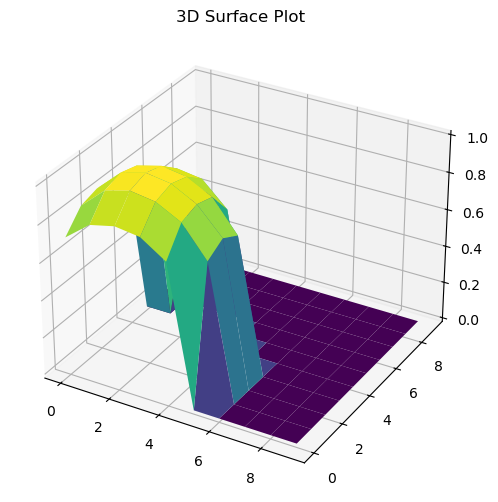

Max value: 1.000, Sum: 25.439, Active cells: 30
Peak position: (2, 2), Place cell index: 22


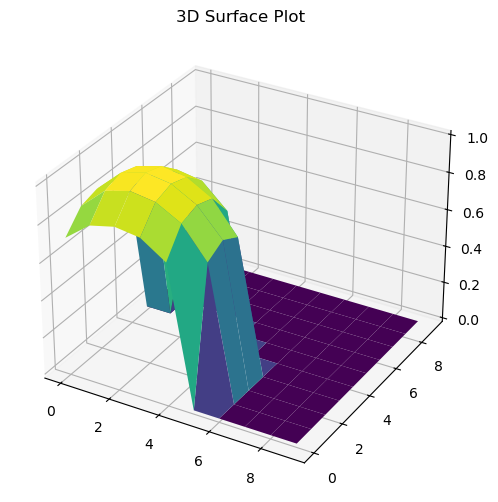

Max value: 1.000, Sum: 24.709, Active cells: 29
Peak position: (2, 2), Place cell index: 22


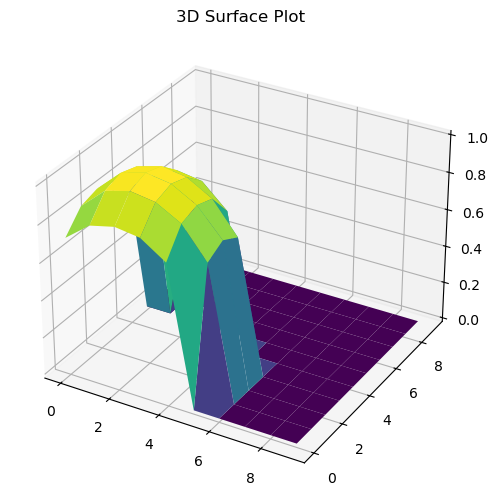

Max value: 1.000, Sum: 23.963, Active cells: 28
Peak position: (2, 2), Place cell index: 22


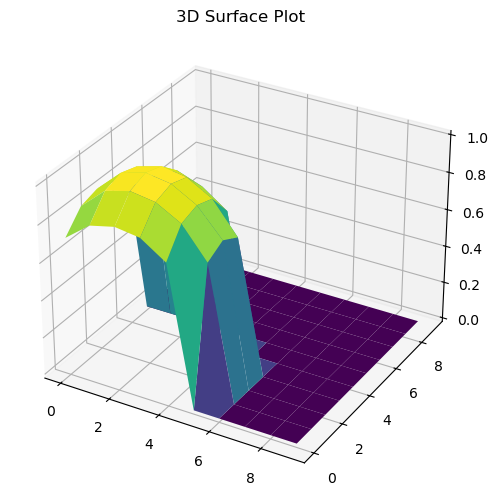

Max value: 1.000, Sum: 23.930, Active cells: 28
Peak position: (2, 2), Place cell index: 22


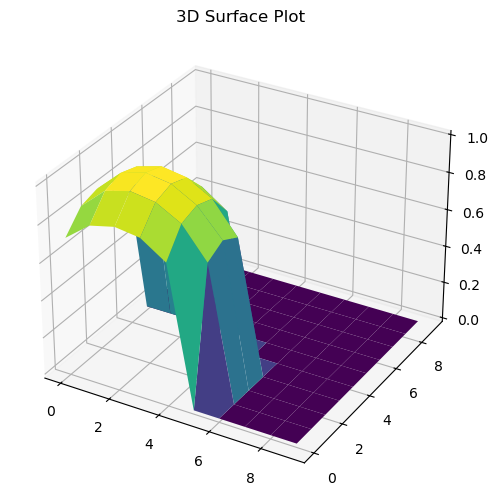

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


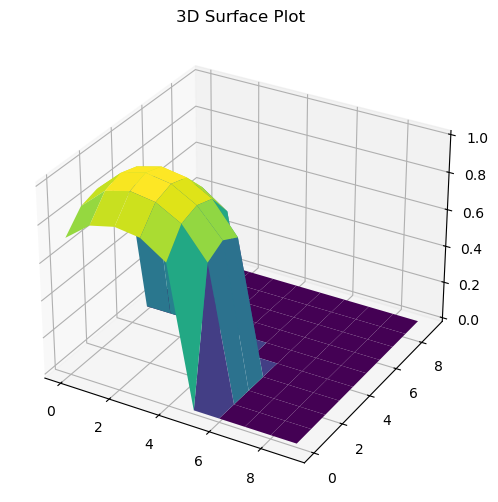

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


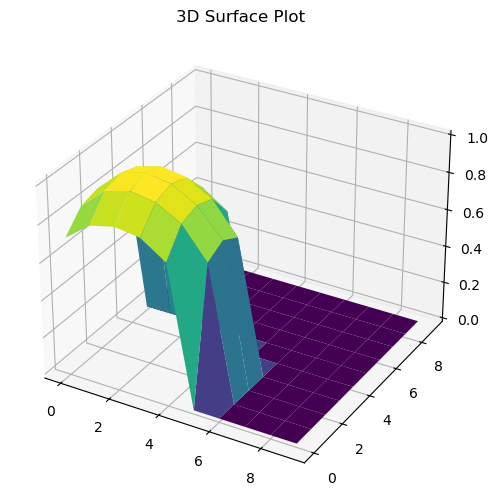

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


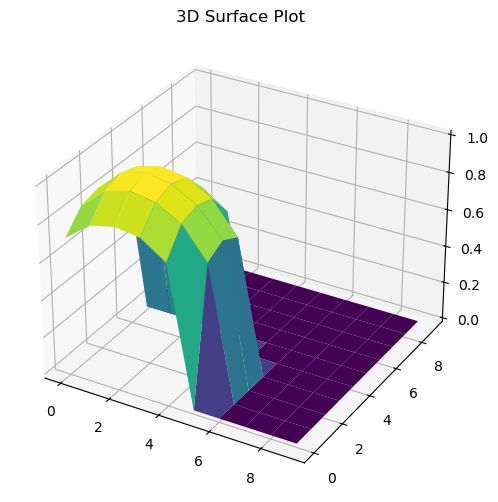

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


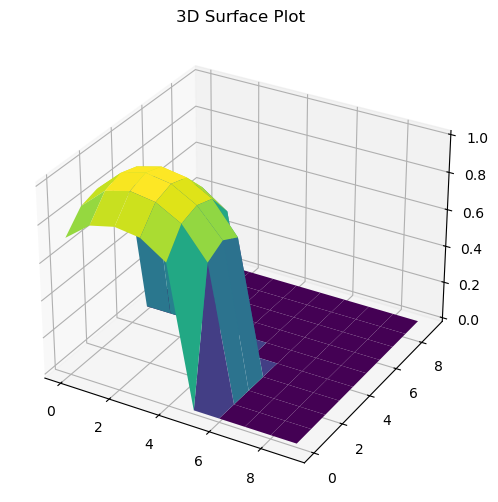

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


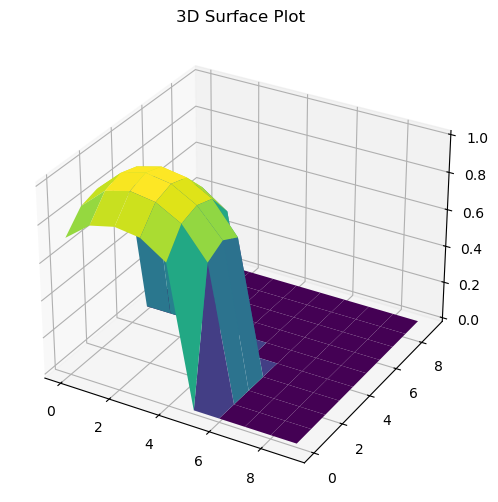

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


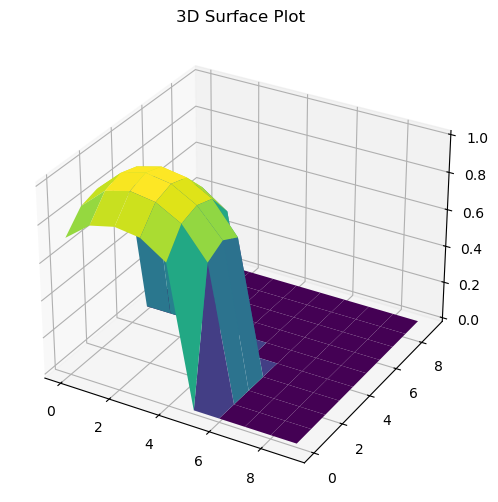

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


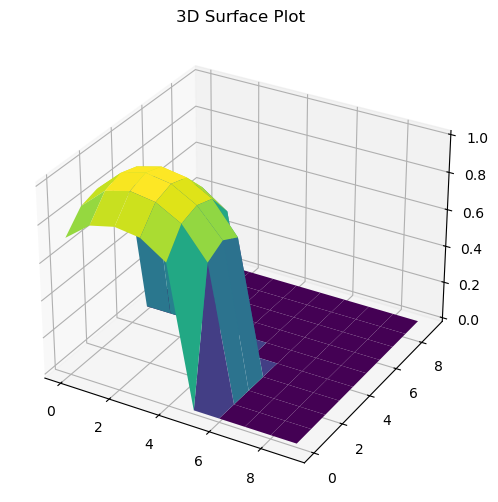

Max value: 1.000, Sum: 23.923, Active cells: 28
Peak position: (2, 2), Place cell index: 22


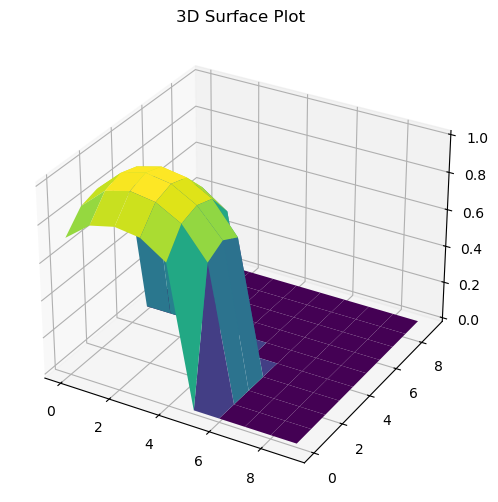

'fixed this by:\n\t•\tApplying sensoryInput[k] only to the specific cell (row, col) corresponding to place cell k.\n\t•\tUsing the row and column from PC_idx to correctly index into NetInput.\n\t•\tNow, sensory input is localized, so the network receives input only at the intended position.'

In [592]:
# Step 4: Calculate the firing of each cell
for _ in range(nIterations):
    NetInput = np.zeros((rows, cols))  # create a temporary store of cell activity so they don't interact

    for k in range(nCells):
        row, col = np.where(PC_idx == k)  # find row and column index of cell

        # Recurrent update from place cell k
        NetInput += weightsMat[:, :, k] * NetAct[row, col]

        # Apply sensory input to the specific location (row, col) only
        NetInput[row, col] += sensoryInput[k]

    # Non-linearity
    NetInput = NetInput - np.min(NetInput)

    if np.max(NetInput) > 0:  # avoid divide-by-zero
        NetInput = NetInput / np.max(NetInput)  # Normalize to values between 0 & 1

    # Threshold
    NetInput = NetInput * (NetInput >= NetThreshold)

    # Update activity
    NetAct = NetInput.copy()

    # DEBUG PRINTS
    max_idx = np.unravel_index(np.argmax(NetAct), NetAct.shape)
    flat_pc_idx = np.ravel_multi_index(max_idx, NetAct.shape)
    print(f"Max value: {np.max(NetAct):.3f}, Sum: {np.sum(NetAct):.3f}, Active cells: {np.count_nonzero(NetAct)}")
    print(f"Peak position: {max_idx}, Place cell index: {flat_pc_idx}")

    # Plot current network state
    create3Dplot(rows, cols, NetAct)  # plot - you need to press Enter to progress on to next iteration

# sensoryInput[k] is a scalar being added across the entire 2D NetInput grid — once per k
# That results in every cell getting 100 additions of 100 scalars, which likely overwhelms spatial specificity
# The bump’s location became unstable and random, even when the sensory input position was fixed.
"""fixed this by:
	•	Applying sensoryInput[k] only to the specific cell (row, col) corresponding to place cell k.
	•	Using the row and column from PC_idx to correctly index into NetInput.
	•	Now, sensory input is localized, so the network receives input only at the intended position."""

In [593]:
# Find the index of the maximum value
max_index = np.unravel_index(np.argmax(NetAct), NetAct.shape)

print("Position of maximum value:", max_index)
print("Place cell index of maximum value:", np.ravel_multi_index(max_index, NetAct.shape))


Position of maximum value: (2, 2)
Place cell index of maximum value: 22


Final peak position (row, col): (2, 2)
Final place cell index: 22


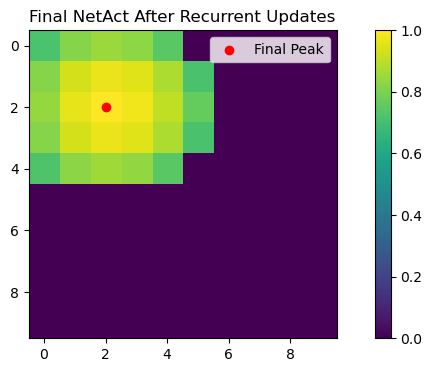

In [594]:
# Plot final activation
plt.figure(figsize=(10, 4))
plt.imshow(NetAct, cmap='viridis')
plt.title("Final NetAct After Recurrent Updates")
plt.colorbar()

# Get and print final peak
final_max_idx = np.unravel_index(np.argmax(NetAct), NetAct.shape)
print("Final peak position (row, col):", final_max_idx)
print("Final place cell index:", np.ravel_multi_index(final_max_idx, NetAct.shape))

plt.scatter(final_max_idx[1], final_max_idx[0], color='red', label='Final Peak')
plt.legend()
plt.show()